MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

Build Super-resolution DEM 0.5m from DEM 1m enhanced by one orthophoto image 0.5m

Source dataset: Elevation1 - Mashhad, Iran

Elevation1 DSM + Pléiades Ortho 0.5m pan-sharpened (Orthoimage included)

https://www.intelligence-airbusds.com/en/9317-sample-imagery-detail?product=18896&keyword=&type=366

In [1]:
from osgeo import gdal
import os
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# select work area
def crop_area(raster):
    return raster.sel(x=slice(730000,730500),y=slice(4012000, 4011500))
def crop_sample(raster):
    return raster.sel(x=slice(730000,730100),y=slice(4011700,4011600))

### Load DEM

In [3]:
# DEM image
dem = crop_area(xr.open_rasterio("data/Mashhad-DEM.tif")[0])
del dem.attrs['units']
dem

<xarray.DataArray (y: 500, x: 500)>
[250000 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 4.012e+06 4.012e+06 4.012e+06 ... 4.012e+06 4.012e+06
  * x        (x) float64 7.3e+05 7.3e+05 7.3e+05 ... 7.305e+05 7.305e+05
Attributes:
    transform:      (1.0, 0.0, 730000.0, 0.0, -1.0, 4012000.0)
    crs:            +init=epsg:32640
    res:            (1.0, 1.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

### Load orthophoto image

In [4]:
# orthophoto image 0.5m for the same area as DEM data above
img = crop_area(xr.open_rasterio("data/7289-40126_Mashhad.tif")[0])

### Regrid DEM 1m on the same grid as orthophoto image 0.5m
This is nearest neighbor interpolation without any data quality enhancement

In [5]:
# define source values
df_dem = dem.to_dataframe(name='dem').dropna().reset_index()
# target grid 
df_grid = img.to_dataframe(name='_').reset_index()[['y','x']]
# nearest neighbor interpolation
tree = cKDTree(list(zip(df_dem.x, df_dem.y)))
distance, indices = tree.query(list(zip(df_grid.x, df_grid.y)), k = 1)
values = df_dem.dem.values[indices]
dem2x = xr.DataArray(values.reshape(img.shape),
                          coords=[img.y,img.x])

### Enhance DEM by orthophoto image
As explained in the article we need to transfer spatial components 0-5m

With pixel size 0.5m the required filter radius is equal to 10 pixels because 10*0.5m = 5m

In [6]:
# low-pass filter
def raster_filter(src, gamma):
    dst = src.copy()
    dst.values = gaussian_filter(dst.values.astype(np.float32),gamma,mode='nearest')
    return dst

# define spectrum components to transfer
radius = 5/img.res[0]

img_lowpass = raster_filter(img, radius)
img_hipass  = img - img_lowpass

dem2x_lowpass = raster_filter(dem2x, radius)
dem2x_hipass  = dem2x - dem2x_lowpass

# caclulate approximate scale factor for short wavelenghs
scale = (img_hipass.max()-img_hipass.min())/(dem2x_hipass.max()-dem2x_hipass.min())
scale

# super-resolution dataset
dem2x_hires = dem2x_lowpass + img_hipass/scale

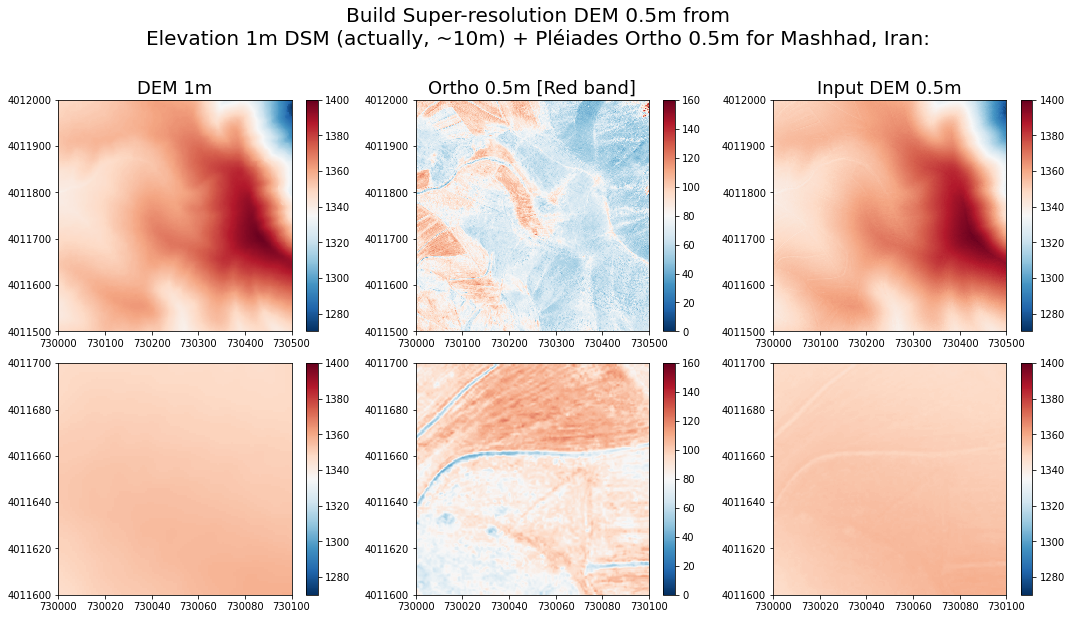

In [7]:
fig, ax = plt.subplots(2,3,figsize=(16,9))
((ax1,ax2,ax3),(ax4,ax5,ax6)) = ax

dem.plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax1)
ax1.set_title('DEM 1m', fontsize=18)
img.plot(vmin=0,vmax=160,cmap='RdBu_r',ax=ax2)
ax2.set_title('Ortho 0.5m [Red band]', fontsize=18)

crop_sample(dem).plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax4)
ax4.set_title('')
crop_sample(img).plot(vmin=0,vmax=160,cmap='RdBu_r',ax=ax5)
ax5.set_title('')

title = """Build Super-resolution DEM 0.5m from
Elevation 1m DSM (actually, ~10m) + Pléiades Ortho 0.5m for Mashhad, Iran:
"""

dem2x_hires.plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax3)
ax3.set_title('Input DEM 0.5m', fontsize=18)

crop_sample(dem2x_hires).plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax6)
ax6.set_title('')

for _ax in ax:
    for __ax in _ax:
        __ax.ticklabel_format(useOffset=False, style='plain')
        __ax.set_xlabel('')
        __ax.set_ylabel('')
        
plt.suptitle(title, fontsize=20)
fig.tight_layout(rect=[0.03, 0.03, 0.97, 1])
#plt.savefig('Super-resolution DEM.jpg', dpi=150)
plt.show()

In [8]:
# compare original and target DEM
float((dem2x_hires-dem2x).mean()),float((dem2x_hires-dem2x).std())

(-0.0076777697540819645, 0.44073131680488586)